## Advanced Time Series Modeling

### Learning Objectives
By the end of this lesson, students should be able to:
- Create a proper train/test split on time series data.
- Identify when seasonality exists in time series data.
- Fit and tune a SARIMAX model.
- Fit a multivariate time series model.

### Review

<details><summary>Check: When do we use an AR (autoregressive) model? (THREAD)</summary>

- We use an AR model when we are measuring/predicting **long-term trends**.
</details>

---

<details><summary>Check: When do we use an MA (moving average) model? (THREAD)</summary>

- We fit an MA model when we anticipate our time series will have **substantial, sudden shocks** in the data.
</details>

In [41]:
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import(
    cross_val_score,
    train_test_split,
    GridSearchCV
)


from sklearn.metrics import mean_squared_error

In [42]:
# Read in data.
stocks = pd.read_csv('../datasets/stocks_data.csv')

> We're going to work with stock data. We have:
- `AAPL`: the monthly volume of stocks traded for AAPL (Apple).
- `DOW`: the monthly volume of stocks traded for DOW (Dow Chemical Company).
- `INTC`: the monthly volume of stocks traded for INTC (Intel).
- `NKE`: the monthly volume of stocks traded for NKE (Nike).
- `SBUX`: the monthly volume of stocks traded for SBUX (Starbucks).
- `YHOO`: the monthly volume of stocks traded for YHOO (Yahoo).

In [43]:
# Reset index to be date.
stocks.index = pd.date_range(start = '1/1/1998',
                                periods = len(stocks['date']),
                                freq = 'M')

# Drop date column.
stocks.drop(columns = 'date', inplace = True)

# Print shape of dataframe.
print(stocks.shape)

# Check head of dataframe.
stocks.head()

(188, 6)


,AAPL,DOW,INTC,NKE,SBUX,YHOO
1998-01-31,429827197.2,1.209317e+08,1.661023e+09,7.959626e+07,293173270.9,850634400
1998-02-28,472442891.2,1.076107e+08,1.557596e+09,1.728604e+08,195688833.4,812745601
1998-03-31,289967681.9,3.199504e+08,1.302454e+09,1.313051e+08,200276117.7,508606400
1998-04-30,204349358.0,8.812538e+07,1.528902e+09,1.122555e+08,169892162.9,435661445
1998-05-31,262567704.3,8.690630e+07,1.324581e+09,9.772757e+07,129467760.4,421181942


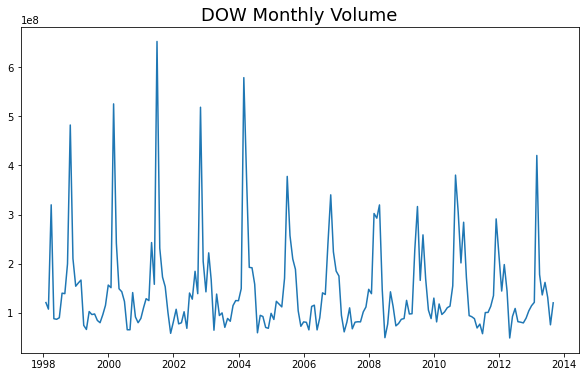

In [44]:
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(stocks['DOW'])
plt.title(label = 'DOW Monthly Volume', fontsize=18)
plt.show();

Do we know anything about the time series? 

- seasonality 
- at approx equal distance appears to be a spike 

In [45]:
# Run this for now - we'll use this later!
stocks['INTC_lag_1'] = stocks['INTC'].shift(1)
stocks.head()

,AAPL,DOW,INTC,NKE,SBUX,YHOO,INTC_lag_1
1998-01-31,429827197.2,1.209317e+08,1.661023e+09,7.959626e+07,293173270.9,850634400,NaN
1998-02-28,472442891.2,1.076107e+08,1.557596e+09,1.728604e+08,195688833.4,812745601,1.661023e+09
1998-03-31,289967681.9,3.199504e+08,1.302454e+09,1.313051e+08,200276117.7,508606400,1.557596e+09
1998-04-30,204349358.0,8.812538e+07,1.528902e+09,1.122555e+08,169892162.9,435661445,1.302454e+09
1998-05-31,262567704.3,8.690630e+07,1.324581e+09,9.772757e+07,129467760.4,421181942,1.528902e+09


<details><summary>What did the last cell of code do?</summary>

- Created a new variable called `INTC_lag_1` that shifts the volume for `INTC` down one value.
</details>

## Train/Test Split

Our goal, as with all train/test splits, is to:
- avoid overfitting in our model, and
- to get an unbiased estimate of model performance on new, "unseen" data.

When fitting a time series model, we shouldn't do a random train-test split like we do with non-correlated data.

Since our goal with time series analysis is almost always to forecast values forward in time, the idea with a time series train/test split is to train on earlier data and test/evaluate on later data.

Most commonly, we'll set our:
- training set to be the "first" 67% - 80% of our data timewise.
- test set be the "last" 20% - 33% timewise.

Let's split our dataframe by taking the first 80% of rows for training and the rest for testing.

In [46]:
# What index gives us our 80th percentile of rows?
stocks.shape[0] * (4 / 5)

150.4

In [47]:
# Set training data to be first 80% of rows.
train = stocks.iloc[0:150]

In [48]:
# Set training data to be last 20% of rows.
test = stocks.iloc[150:]

**Bonus**: Cross-validation is also more complicated with time series data; you can check out more [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) and [here](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/).

In [49]:
# Import ARIMA model.
from statsmodels.tsa.arima.model import ARIMA

In [50]:
# Instantiate an AR(1) model on training data.
# Note this training data consists of the 
# time periods 0 through 149.
ar1 = ARIMA(endog = train['DOW'],
            order = (1, 0, 0)) # (p, d, q)

# Fit AR(1) model.
model = ar1.fit()

# Generate predictions based on test set.
# Start at time period 150 and end at 187.
preds = model.predict(start=150, end=187)

# Evaluate predictions.
mean_squared_error(test['DOW'], preds)

7476280116279197.0

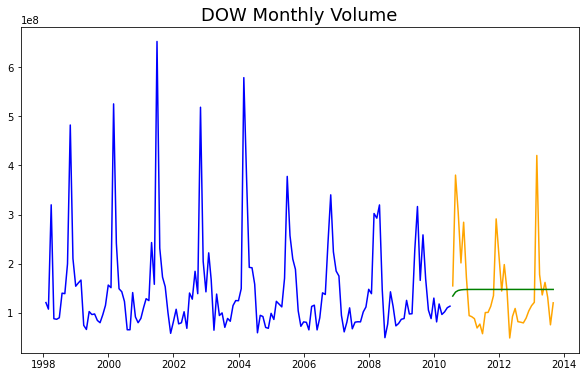

In [51]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['DOW'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['DOW'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds, color = 'green')

plt.title(label = 'DOW Monthly Volume', fontsize=18)
plt.show();

This isn't a particularly good model. Let's see if we can improve it by fitting an ARIMA model.

Remember:
$$
\begin{eqnarray*}
    ARIMA(p,d,q) \Rightarrow Y_t - Y_{t-d} &=& AR(p) + MA(q) \\
    Y_t - Y_{t-d} &=& \mu + \sum_{k=1}^p \beta_kY_{t-k} + \sum_{i=1}^q w_i\varepsilon_{t-i} + \varepsilon_t
\end{eqnarray*}
$$

<details><summary>Check: What assumption must be met in order for us to fit an ARIMA model?</summary>

- Stationarity
</details>

---

<details><summary>Check: How do we check whether or not this assumption is met?</summary>

- Visually examining the original data plot (for a constant mean) and autocorrelation plot (for autocorrelation).
- Execute the augmented Dickey-Fuller test.
</details>

In [52]:
# Import Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

# Define function to easily interpret results.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Execute test on training data.
interpret_dftest(adfuller(train['DOW']))

Test Statistic   -7.508783e+00
p-value           4.067515e-11
dtype: float64

In [53]:
adfuller(train['DOW'])

(-7.508783208700509,
 4.0675153371843944e-11,
 13,
 136,
 {'1%': -3.4793722137854926,
  '5%': -2.8830370378332995,
  '10%': -2.578233635380623},
 5295.594044584851)

<details><summary>Check: How would you interpret this $p$-value?</summary>

- Because $p$ is less than our reasonable choices for $\alpha$, we have enough evidence to reject the null hypothesis and we accept that our time series is stationary.
</details>

### Choosing the right values of $p$, $d$, and $q$.

You can get a sense for which parameters will work best based on autocorrelation and partial autocorrelation charts.

**Note**: We will walk through this algorithm, but this algorithm will be a helpful reference.

Below are some general guidelines (edited from [this site](https://people.duke.edu/~rnau/411arim3.htm) and [this site](https://people.duke.edu/~rnau/arimrule.htm)):
1. **Start by finding the correct value of $d$.** This can be done by differencing your data and by checking the results of your Dickey-Fuller test.
2. **Generate the PACF (partial autocorrelation function) on your differenced data.** If your PACF has a sharp cut-off and the first lag of your ACF (autocorrelation function) value is positive, choose an $AR(p)$ term where $p$ is the lag in the PACF after the cut-off.
3. **Generate the ACF on your differenced data.** If the ACF has a sharp cut-off and the lag-1 ACF value is negative, choose an $MA(q)$ term where $q$ is the lag in the ACF after the cut-off.
4. If both the ACF and PACF show a gradual decay, an ARMA model is likely appropriate as opposed to AR or MA alone. This is normally done through a "manual GridSearch."
    
In general, you should first try to choose an AR or MA model as opposed to an ARMA model, if you can. It is possible for the AR and MA terms to work against each other in the model and create an overly complex representation.

**In summary**: there's a lot of guessing and checking involved... but the Dickey-Fuller test, the ACF plot, and the PACF plot will be your friends here!

### `We checked stationarity ok, we need to check seasonality`

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

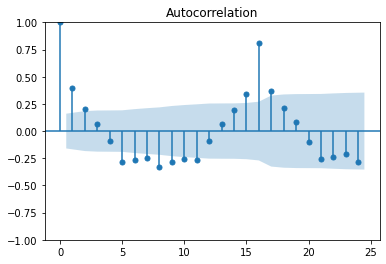

In [55]:
# Generate autocorrelation plot on training data.
plot_acf(train['DOW'], lags = 24);

# Note: we would generate the ACF plot on 
# differenced data, if we needed to difference
# in order to achieve stationarity!

# step 1 - lag the value 
# step 2: take the correlation 


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


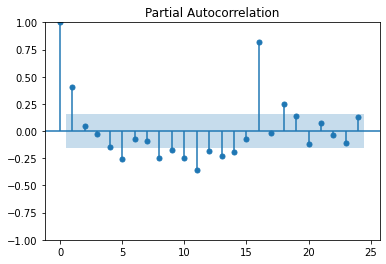

In [56]:
# Generate partial autocorrelation plot on training data.
# pacf - means partial 


plot_pacf(train['DOW'], lags = 24);

# Note: we would generate the PACF plot on 
# differenced data, if we needed to difference
# in order to achieve stationarity!


# step 3: Example t -2, 3rd from the left
# t -2 is correlated with t-0 
# BUT, t-2 is ALSO correlated with t-1 
# Therefore, t-2 is correlated with t-0 directly (by iteself)
# and indirectkly (through t-1)

# hence the PACF - removes the indirect correlation first (ie, removing t-1)
# dark blue area - confidence level (significant difference from zero)
# IF LIES WITHIN THE BAND -->> `not enough that autocoorelation is significantly differnet from zero`

**Does my PACF have a sharp cut-off?**
> It appears so. I observe a sharp cut-off between lags 0 and 1 as well as a sharp cut-off between lags 1 and 2 in this image. I'll fit two models and compare them (one assuming the cut-off is between 0 and 1, and one assuming the cut-off is between 1 and 2).

**Is the first-lag value in the autocorrelation plot positive or negative?**
> It is positive. (Note that the first-lag value should always be the same in the ACF and PACF plots.)

**What model should we fit?**
> "If your PACF has a sharp cut-off and the first lag of your ACF (autocorrelation function) value is positive, choose an $AR(p)$ term where $p$ is the lag in the PACF after the cut-off." Thus, I will fit an $AR(1)$ model and an $AR(2)$ model and see how well they perform.

In [57]:
# Instantiate an AR(1) model on training data.
# Note this training data consists of the 
# time periods 0 through 149.
ar1 = ARIMA(endog = train['DOW'],
            order = (1, 0, 0)) # (p, d, q)

# Fit AR(1) model.
model = ar1.fit()

# Generate predictions based on test set.
# Start at time period 150 and end at 187.
preds = model.predict(start=150, end=187)

# Evaluate predictions.
mean_squared_error(test['DOW'], preds)

7476280116279197.0

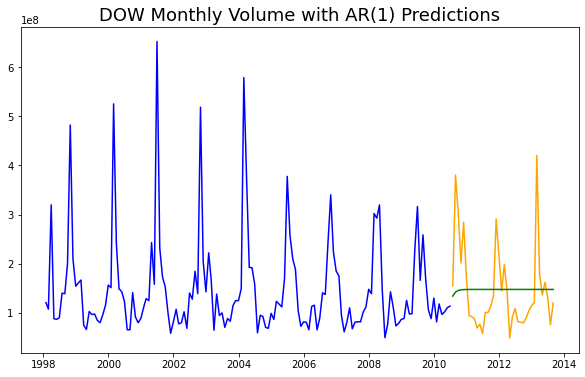

In [58]:
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['DOW'], color = 'blue')
plt.plot(test['DOW'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'DOW Monthly Volume with AR(1) Predictions', fontsize=18)
plt.show();

In [59]:
# Instantiate an AR(2) model on training data.
# Note this training data consists of the 
# time periods 0 through 149.
ar2 = ARIMA(endog = train['DOW'],
            order = (2, 0, 0)) # (p, d, q)

# Fit AR(2) model.
model = ar2.fit()

# Generate predictions based on test set.
# Start at time period 150 and end at 187.
preds = model.predict(start=150, end=187)

# Evaluate predictions.
mean_squared_error(test['DOW'], preds)

7516079092964477.0

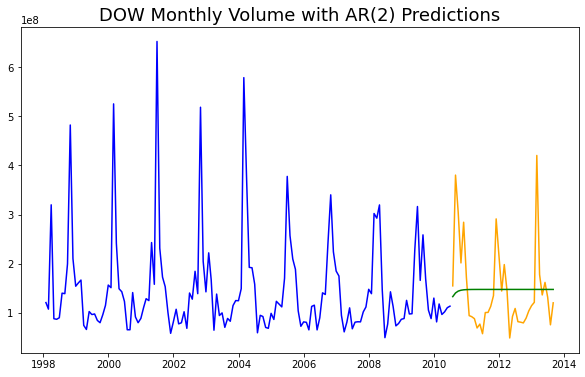

In [60]:
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['DOW'], color = 'blue')
plt.plot(test['DOW'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'DOW Monthly Volume with AR(2) Predictions', fontsize=18)
plt.show();

Yikes. Neither of these appear to be particularly good, either. What else can we try?

## Seasonal Model

We can think of seasonality as a repeating pattern (like a cycle) that occurs over time.

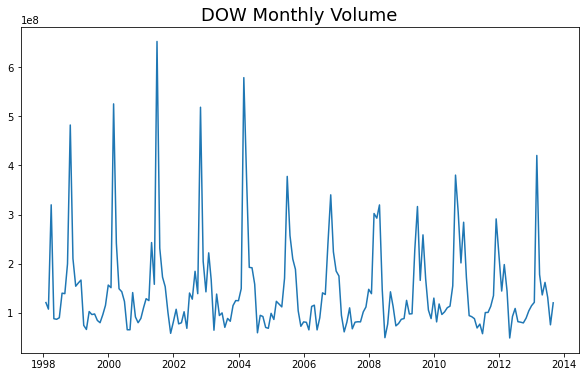

In [61]:
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(stocks['DOW'])
plt.title(label = 'DOW Monthly Volume', fontsize=18)
plt.show();

<details><summary>By looking at this data, is there is strong evidence of seasonality? If so, what evidence supports seasonality?</summary>

- Yes! There are repeated spikes that seem to occur every 16 months or so.
- If we look back on our PACF plot, we note that there is a significant value around lag 16.
</details>

C:\Users\Admin\.conda\envs\myenv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


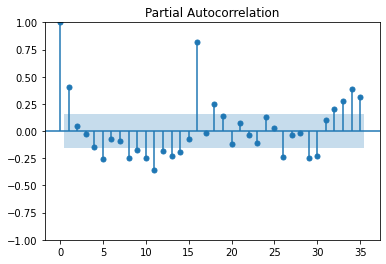

In [62]:
# Generate partial autocorrelation plot on training data.
plot_pacf(train['DOW'], lags = 35);

`Every 16 cycle fit another arima` 

that cadence arima is known as the seasonal component

We can fit a **seasonal ARIMA (SARIMA) model** to our data. This model will:
- Have the ARIMA components we've described thus far, which are good for stationary trends.
- Include a seasonal component that will allow us to also account for seasonality that occurs over time.

The SARIMA model is given by $ARIMA(p, d, q) × (P, D, Q, S)$, where:
- $ARIMA(p, d, q)$ is the ARIMA model we've already discussed with AR order $p$, MA order $q$, and differencing order $d$.
- $(P, D, Q, S)$ refers to the seasonal AR order $P$, the seasonal MA order $Q$, the seasonal differencing order $D$, and the length of the season $S$.

In [63]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

1.0364776849221072e+16


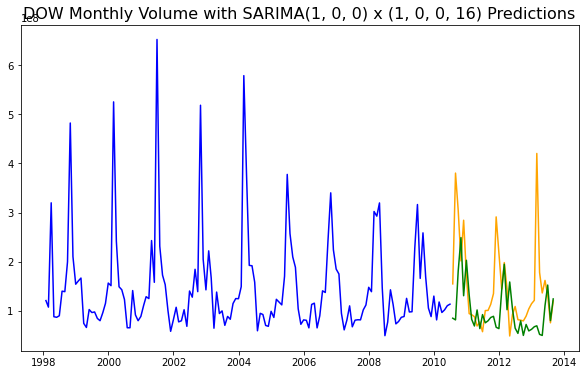

In [64]:
# Fit a SARIMA(1, 0, 0) x (1, 0, 0, 16) model.

sarima = SARIMAX(endog = train['DOW'],
                 order = (1, 0, 0),              # (p, d, q)
                 seasonal_order = (1, 0, 0, 16)) # (P, D, Q, S) 
                 # we see every 16 times 
                 # t
                 # t+1 
                 # t+16 (added seasonal)
                 #...
                 # t + 32 (added seasonal)
                 # ...
                 # t + 48 (added seasonal) 

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
# Start at time period 150 and end at 187.
preds = model.predict(start=150, end=187)

# Evaluate predictions.
print(mean_squared_error(test['DOW'], preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['DOW'], color = 'blue')
plt.plot(test['DOW'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'DOW Monthly Volume with SARIMA(1, 0, 0) x (1, 0, 0, 16) Predictions', fontsize=16)
plt.show();

In [2]:
1.0364776849221072e+16 - 7516079092964477.0

2848697756256595.0

Our predictions are more complex and visually better match the data!  Let's try tweaking parameters $P$, $D$, $Q$, and $S$ to see how we can get our green line to better match the orange line.

We will assume that our value, $S$, is 16 as it appears (based on the ACF plot and PACF plot) that each season/period is approximately 16 months.

Generally, this is "most easily" done through a manual GridSearch process.

In [76]:
# Starting MSE and (P, D, Q).
mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            try:
                # Instantiate SARIMA model.
                sarima = SARIMAX(endog = train['DOW'],
                                 order = (1, 0, 0),              # (p, d, q)
                                 seasonal_order = (P, D, Q, 16)) # (P, D, Q, S)

                # Fit SARIMA model.
                model = sarima.fit()

                # Generate predictions based on training set.
                # Start at time period 0 and end at 149.
                preds = model.predict(start=train.index[0], end=train.index[-1])

                # Evaluate predictions.
                print(f'The MSE for (1, 0, 0)x({P},{D},{Q},16) is: {mean_squared_error(train["DOW"], preds)}')
                
                # Save for final report.
                if mse > mean_squared_error(train["DOW"], preds):
                    mse = mean_squared_error(train["DOW"], preds)
                    final_P = P
                    final_D = D
                    final_Q = Q
                
            except:
                pass

print(f'Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x({final_P},{final_D},{final_Q},16).')
print(f'This model has an MSE of {mse}.')

The MSE for (1, 0, 0)x(0,0,0,16) is: 1.1029826650791944e+16
The MSE for (1, 0, 0)x(0,1,0,16) is: 5133809736019334.0
The MSE for (1, 0, 0)x(0,2,0,16) is: 1.0747901813219578e+16
The MSE for (1, 0, 0)x(0,0,1,16) is: 6374465265599925.0
The MSE for (1, 0, 0)x(0,1,1,16) is: 5087661968064538.0
The MSE for (1, 0, 0)x(0,2,1,16) is: 6594498648813748.0


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 0, 0)x(0,0,2,16) is: 5200314198254613.0
The MSE for (1, 0, 0)x(0,1,2,16) is: 5116976182167771.0


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 0, 0)x(0,2,2,16) is: 6475389603024875.0
The MSE for (1, 0, 0)x(1,0,0,16) is: 4077314900355084.0
The MSE for (1, 0, 0)x(1,1,0,16) is: 5093031343824250.0
The MSE for (1, 0, 0)x(1,2,0,16) is: 7023033168119622.0
The MSE for (1, 0, 0)x(1,0,1,16) is: 4036492874313790.5
The MSE for (1, 0, 0)x(1,1,1,16) is: 5165678474116140.0
The MSE for (1, 0, 0)x(1,2,1,16) is: 6448094854037729.0
The MSE for (1, 0, 0)x(1,0,2,16) is: 4035242417682169.0
The MSE for (1, 0, 0)x(1,1,2,16) is: 5165702080312992.0


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Admin\.conda\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 0, 0)x(1,2,2,16) is: 6519263870587219.0
The MSE for (1, 0, 0)x(2,0,0,16) is: 4032588774799592.0
The MSE for (1, 0, 0)x(2,1,0,16) is: 5118810139051598.0
The MSE for (1, 0, 0)x(2,2,0,16) is: 6547577285282720.0
The MSE for (1, 0, 0)x(2,0,1,16) is: 4034980675857070.0
The MSE for (1, 0, 0)x(2,1,1,16) is: 5161709369383247.0
The MSE for (1, 0, 0)x(2,2,1,16) is: 6425683306968761.0
The MSE for (1, 0, 0)x(2,0,2,16) is: 4035863419349146.5
The MSE for (1, 0, 0)x(2,1,2,16) is: 5156346479998830.0


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 0, 0)x(2,2,2,16) is: 6505674706296477.0
Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(2,0,0,16).
This model has an MSE of 4032588774799592.0.


In [71]:
# Starting MSE and (P, D, Q).
mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            try:
                # Instantiate SARIMA model.
                sarima = SARIMAX(endog = train['DOW'],
                                 order = (1, 0, 0),              # (p, d, q)
                                 seasonal_order = (P, D, Q, 16)) # (P, D, Q, S)

                # Fit SARIMA model.
                model = sarima.fit()

                # Generate predictions based on training set.
                # Start at time period 0 and end at 149.
                preds = model.predict(start=test.index[0], end=test.index[-1])

                # Evaluate predictions.
                print(f'The MSE for (1, 0, 0)x({P},{D},{Q},16) is: {mean_squared_error(test["DOW"], preds)}')
                
                # Save for final report.
                if mse > mean_squared_error(test["DOW"], preds):
                    mse = mean_squared_error(test["DOW"], preds)
                    final_P = P
                    final_D = D
                    final_Q = Q
                
            except:
                pass

print(f'Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x({final_P},{final_D},{final_Q},16).')
print(f'This model has an MSE of {mse}.')

The MSE for (1, 0, 0)x(0,0,0,16) is: 2.4259283225488664e+16
The MSE for (1, 0, 0)x(0,1,0,16) is: 1.1404266386027702e+16
The MSE for (1, 0, 0)x(0,2,0,16) is: 2.5051471020307828e+16
The MSE for (1, 0, 0)x(0,0,1,16) is: 1.9903642136141196e+16
The MSE for (1, 0, 0)x(0,1,1,16) is: 1.120230410717705e+16
The MSE for (1, 0, 0)x(0,2,1,16) is: 1.2973895008583398e+16


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 0, 0)x(0,0,2,16) is: 1.7378253483594752e+16
The MSE for (1, 0, 0)x(0,1,2,16) is: 1.140982163587384e+16


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 0, 0)x(0,2,2,16) is: 1.286696572544833e+16
The MSE for (1, 0, 0)x(1,0,0,16) is: 1.0364776849221072e+16
The MSE for (1, 0, 0)x(1,1,0,16) is: 1.1234043360227206e+16
The MSE for (1, 0, 0)x(1,2,0,16) is: 1.5704204984551788e+16
The MSE for (1, 0, 0)x(1,0,1,16) is: 9789959377424664.0
The MSE for (1, 0, 0)x(1,1,1,16) is: 1.1386094670535438e+16
The MSE for (1, 0, 0)x(1,2,1,16) is: 1.2911869905567576e+16
The MSE for (1, 0, 0)x(1,0,2,16) is: 9801918077683876.0
The MSE for (1, 0, 0)x(1,1,2,16) is: 1.1231252439391894e+16


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Admin\.conda\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 0, 0)x(1,2,2,16) is: 1.2946720961806434e+16
The MSE for (1, 0, 0)x(2,0,0,16) is: 9854648625776244.0
The MSE for (1, 0, 0)x(2,1,0,16) is: 1.1414871548842502e+16
The MSE for (1, 0, 0)x(2,2,0,16) is: 1.3874440778249458e+16
The MSE for (1, 0, 0)x(2,0,1,16) is: 9803018494842268.0
The MSE for (1, 0, 0)x(2,1,1,16) is: 1.1222769878924126e+16
The MSE for (1, 0, 0)x(2,2,1,16) is: 1.3291345073205668e+16
The MSE for (1, 0, 0)x(2,0,2,16) is: 9794945213623658.0
The MSE for (1, 0, 0)x(2,1,2,16) is: 1.1230509599961292e+16


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (1, 0, 0)x(2,2,2,16) is: 1.2935957798651306e+16
Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(1,0,1,16).
This model has an MSE of 9789959377424664.0.


<details><summary>What should our main concerns be about a manual GridSearch process like this?</summary>

- The amount of time it takes to fit our models!
- We aren't cross-validating; we're only evaluating on all of our training data, which will likely end up overfitting. (Cross-validation is also more complicated with time series data; you can check out more [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) and [here](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/).)
</details>

9854648625776244.0


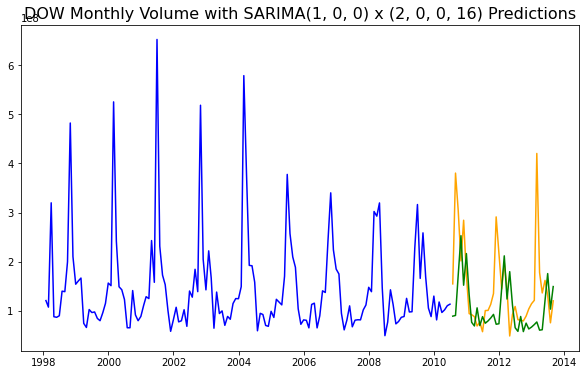

In [68]:
# Fit and visualize a SARIMA(1, 0, 0) x (2, 0, 0, 16) model.

sarima = SARIMAX(endog = train['DOW'],
                 order = (1, 0, 0),              # (p, d, q)
                 seasonal_order = (2, 0, 0, 16)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
# Start at time period 150 and end at 187.
preds = model.predict(start=150, end=187)

# Evaluate predictions.
print(mean_squared_error(test['DOW'], preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['DOW'], color = 'blue')
plt.plot(test['DOW'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'DOW Monthly Volume with SARIMA(1, 0, 0) x (2, 0, 0, 16) Predictions', fontsize=16)
plt.show();

In [3]:
9854648625776244.0 - 7516079092964477.0

2338569532811767.0

In [1]:
9854648625776244.0 - 1.0364776849221072e+16

-510128223444828.0

# eXogenous Predictors

In time series analysis, we spend most of our time focused on how we can quantify the relationship between $Y_t$ and $Y_{t-k}$ and then use that relationship to forecast values of $Y_t$.

Future performance of Dow Chemical probably isn't limited to just past performance of Dow Chemical. The performance of Dow Chemical will be based on a whole host of things: how well its competitors are doing, how agriculture is doing (one of Dow's focuses), and so on.

However, we can (and should!) still use $X$ variables in our data.
- In `statsmodels` and in various disciplines like econometrics, the $X$ variables are known as `exogenous`.
- More on exogenous/endogenous [here](http://www.statsmodels.org/stable/endog_exog.html).

In fact, the SARIMAX model stands for "Seasonal Autoregressive Integrated Moving Average with eXogenous regressors model."

#### One important practical note: 
If you're going to fit a SARIMAX model, make sure that your $X$ variable makes sense - especially timewise.
> For example, if we want to forecast Dow Chemical stock volume for December 2018 based on Intel's stock volume, I probably shouldn't use Intel's stock volume in December 2018 as an input. (I'm forecasting a value of $Y$ when I wouldn't have access to that value of $X$.)

I should probably lag my $X$ variable by at least one time point. 


| Index | $DOW_t$ | $INTC_{t-1}$ |
|-------|---------|--------------|
| 1     | $DOW_1$ | NA           |
| 2     | $DOW_2$ | $INTC_1$     |
| 3     | $DOW_3$ | $INTC_2$     |
| 4     | $DOW_4$ | $INTC_3$     |

Remember: we did this above!
> `stocks['INTC_lag_1'] = stocks['INTC'].shift(1)`

In [74]:
train.shape

(150, 7)

In [75]:
test.shape

(38, 7)

8401122844689347.0


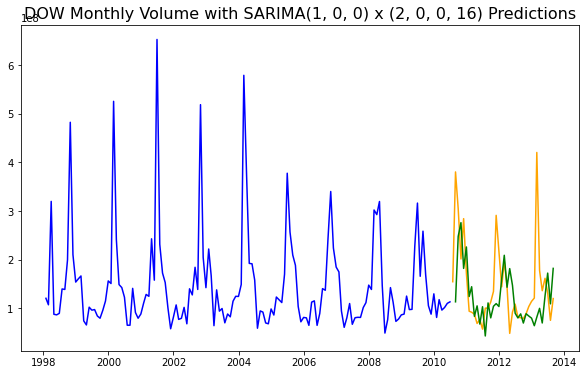

In [69]:
# Fit and visualize a SARIMAX(1, 0, 0) x (2, 0, 0, 16) model.

sarima = SARIMAX(endog = train['DOW'].iloc[1:],  # drop the na cause got one lag from intc lag 1 
                 order = (1, 0, 0),              # (p, d, q)
                 seasonal_order = (2, 0, 0, 16), # (P, D, Q, S)
                 exog = train['INTC_lag_1'].iloc[1:])

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
# Start at time period 150 and end at 186.
preds = model.predict(start=150, end=186, exog=test[['INTC_lag_1']])

# Evaluate predictions.
print(mean_squared_error(test['DOW'].iloc[1:], preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['DOW'], color = 'blue')
plt.plot(test['DOW'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'DOW Monthly Volume with SARIMA(1, 0, 0) x (2, 0, 0, 16) Predictions', fontsize=16)
plt.show();

In general
arima models usually will predict some mean value 
very quickyly (eg. after 3-5 time periods, it will 
output the mean of the last 5-15 time periods)

This is due to the inability to take into 
account seasonality 

you need `SARIMA MODEL`

by adding another arima component, this arima component
represents another time series within the time series, 
where we consider only values that have S spaciing apart. 
(today it was 16)

SARIMAX model is an addition to SARIMA model 
because it adds in X-ogenours variables 
so you can use another collumn to preduct the price of the DOW STOCK 

`you must lag your otherstock appropriately`

## Wrap-Up
We have covered **a lot** about time series analysis:
- Pandas tricks for handling time series data.
- Autocorrelation and partial autocorrelation.
- Autoregressive models.
- Moving average models.
- Integrated autoregressive and moving average models.
- Properly creating a train/test split for time series data.
- Fitting a model that accounts for seasonality.
- Tuning model parameters (and some of the pitfalls of doing so).
- Fittng a time series model with additional independent (exogenous) variables.

There's so much information about time series analysis out there; we've only just scratched the surface! However, hopefully you have greater context for how to properly handle time series problems and what to keep your eye out for as you build models with some [temporal](http://desktop.arcgis.com/en/arcmap/10.3/map/time/what-is-temporal-data.htm) component.

### Interested in exploring more?
- Fit a model forecasting Google's volume based on four other tech stocks: Facebook, Apple, Intel, and Yahoo.
- Explore cross-validation ([here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) and [here](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)) in time series data for better performance.
- Rather than using a metric like MSE or $R^2$, consider the application here. If you build an algorithm that can help you decide whether to buy/sell/hold stock, then you could quantify that by seeing how much money you might gain/lose if you had applied your models to your test set!

### Choosing the right values of $P$, $D$, and $Q$. (BONUS)

You can get a sense for which parameters will work best based on autocorrelation and partial autocorrelation charts by following a similar process to above. **Specifically, this time, we want to look at our ACF and PACF charts but focus only on multiples of $S$ (in this case, 16)**.